# Testing bias metrics and mitigation algorithms on the Adult Income dataset

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from Sampler import Sampler
from utility import *
from matplotlib.gridspec import GridSpec
import os

path = 'imgs/adult'

In [2]:
def load_dataset():
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                'occupation','relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    adult_df = pd.read_csv('adult/adult.data', names=column_names)
    adult_df.drop(adult_df[(adult_df['race'] != ' Black') & (adult_df['race'] != ' White')].index,inplace=True)
    adult_df.loc[adult_df['native-country'] == ' ?', 'native-country'] = 'Not known'
    return adult_df

## Dataset description

The Adult Income dataset contains informations about the income of people extracted from the 1994 Census database. Prediction task is to determine whether a person makes over 50K a year. It has been shown that the dataset is bias in favor of white men and against women and people of other races.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier. In this way it is no more possible to predict the sensitive variable _S_ from the unsensitive attributes.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier.
>
>**NB:** Categorical data must be transformed in ordered values

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [3]:
adult_df = load_dataset()
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
adult_df.shape

(30940, 15)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


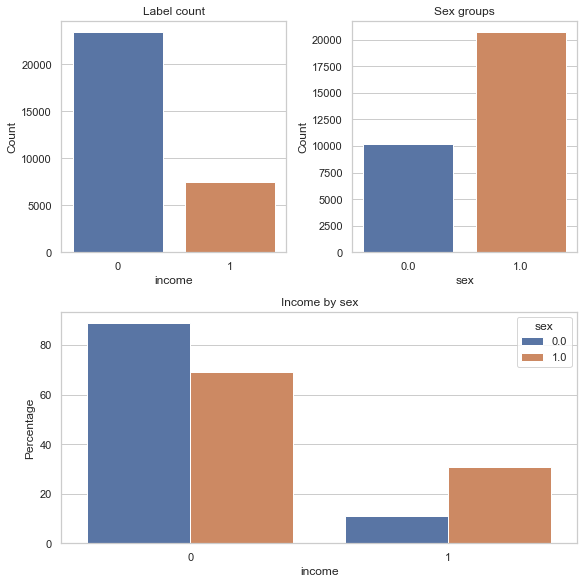

In [53]:
fig = plt.figure(constrained_layout=True, figsize=(8,8))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
#fig,ax = plt.subplots(2,2,figsize=(10,10))
sns.barplot(x='income', y='percentage', 
            data=adult_df[['sex','income']].groupby('sex')['income'].value_counts(normalize=True).rename('percentage').mul(100).reset_index(),
            hue='sex', ax=ax3)
ax3.set(ylabel='Percentage', title="Income by sex")
sns.countplot(x='income', data=adult_df, ax=ax1)
sns.countplot(x='sex', data=adult_df, ax=ax2)

ax2.set(ylabel='Count', title="Sex groups")
ax1.set(ylabel='Count', title="Label count")
plt.savefig(os.path.join(path, 'adult_distr.pdf'))
plt.show()

So we are in an **Unbalanced Bias Dataset** case.

## Dataset transformation

In [6]:
lab_enc = LabelEncoder()
ord_enc = OrdinalEncoder()

In [7]:
adult_df['age_class'] = pd.cut(adult_df['age'],
                               bins=[0,9,19,29,39,49,59,69,99],
                               labels=['age<10','age between 10 and 20','age between 20 and 30',
                                       'age between 30 and 40','age between 40 and 50',
                                       'age between 50 and 60','age between 60 and 70','age>70']
                              )
adult_df['hour-per-week-class'] = pd.cut(adult_df['hours-per-week'],
                               bins=[0,9,19,29,39,49,99],
                               labels=['hour<10','hours between 10 and 20','hours between 20 and 30',
                                       'hours between 30 and 40','hour between 40 and 50',
                                       'hour>70']
                              )
adult_df.drop(labels=['hours-per-week','workclass','fnlwgt','capital-gain','capital-loss','age','education-num'],
              axis=1,inplace=True)
adult_df = adult_df.join(pd.get_dummies(adult_df['education'])).drop('education',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['marital-status'])).drop('marital-status',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['occupation'])).drop('occupation',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['relationship'])).drop('relationship',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['native-country'])).drop('native-country',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['age_class'])).drop('age_class',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['hour-per-week-class'])).drop('hour-per-week-class',axis=1)
adult_df['income'] = lab_enc.fit_transform(adult_df['income'])
adult_df[['sex','race']] = ord_enc.fit_transform(adult_df[['sex','race']])

# Bias dataset and classification metrics

Create a StructuredDataset object to which apply fairness metrics and methods

In [8]:
unprivileged_group = [{'sex': 0}]
privileged_group = [{'sex': 1}]

In [9]:
data = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=adult_df, label_names=['income'], protected_attribute_names=['sex'])

## Bias Dataset

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.8121
Statistical parity: -0.3554
Disparate impact: 0.2837
Average odds: -0.2234
Equal opportunity: -0.1954
Theil index: 0.0823


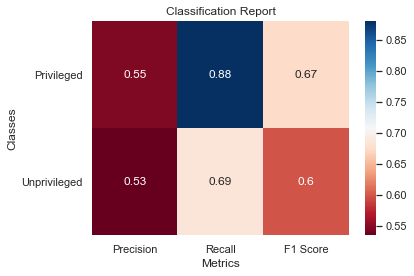

In [10]:
class_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    data, privileged_group, unprivileged_group)

## Reweighing

In [11]:
rw_data = data.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7990
Statistical parity: -0.1896
Disparate impact: 0.5542
Average odds: -0.0292
Equal opportunity: 0.0348
Theil index: 0.0906


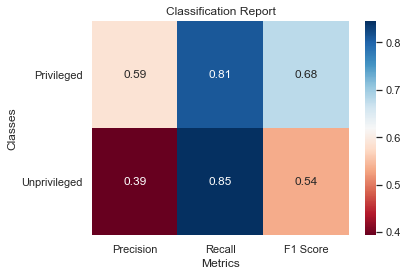

In [12]:
rw_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_data, privileged_group, unprivileged_group, debiaser=rw)

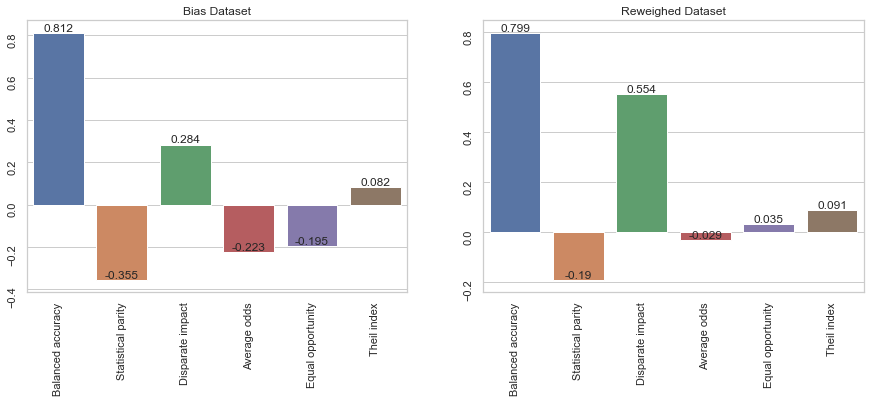

In [13]:
plot_metrics_comparison(class_metrics, rw_class, "Bias Dataset", "Reweighed Dataset")
plt.show()

## Disparate Impact Remover

First we will apply the DIR to the One Hot Encoded dataset and see if it has some effects on the bias mitigation

In [14]:
dir_data = data.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

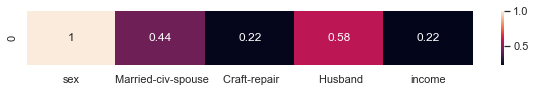

In [15]:
df = dir_data.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[corr[0] > .2].T, ax=ax, annot=True)
plt.show()

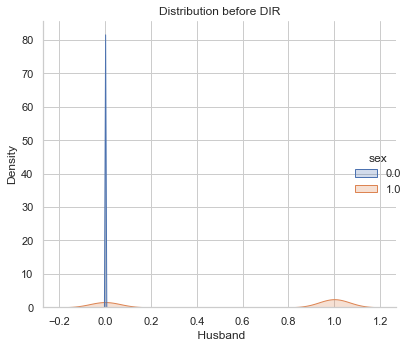

In [16]:
sns.displot(data=df, x=' Husband', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution before DIR')
plt.tight_layout()
plt.savefig('dir_cat_bf.pdf')
plt.show()

Apply DIR and check correlation changes:

In [17]:
di = DisparateImpactRemover(sensitive_attribute='sex')
dir_data_trans = di.fit_transform(dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


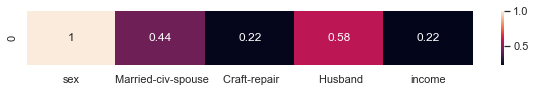

In [18]:
df = dir_data_trans.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[corr[0] > .2].T, ax=ax, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


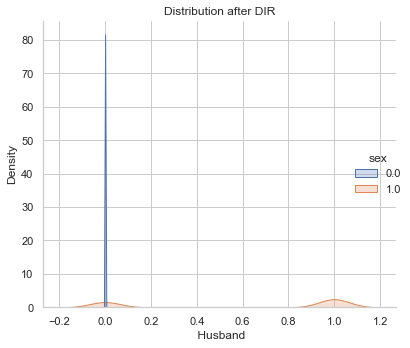

In [19]:
sns.displot(data=df, x=' Husband', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution after DIR')
plt.tight_layout()
plt.savefig('dir_cat_aft.pdf')
plt.show()

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.8096
Statistical parity: -0.3156
Disparate impact: 0.3477
Average odds: -0.1679
Equal opportunity: -0.1193
Theil index: 0.0833


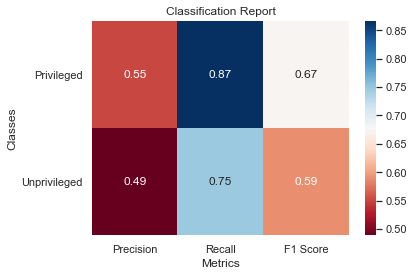

In [20]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    dir_data, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


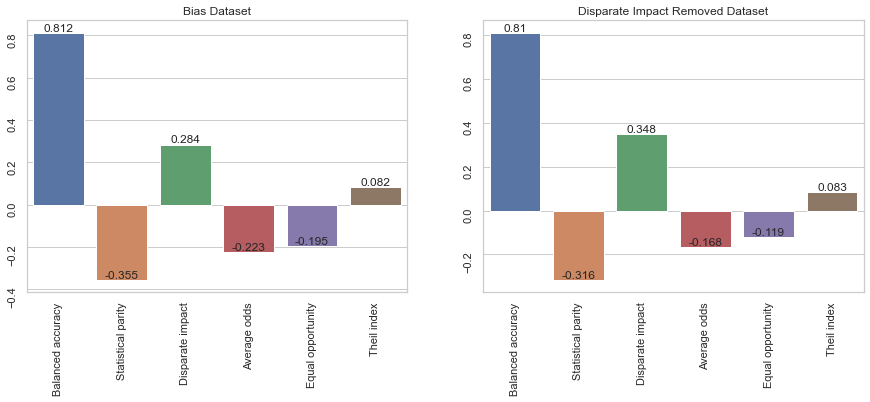

In [21]:
plot_metrics_comparison(class_metrics, dir_class, 'Bias Dataset', 'Disparate Impact Removed Dataset')
plt.show()

## Modified Reweighing (Sampling)

In [22]:
sampled_data = data.copy()
sampler = Sampler(round_level=3)

### Classification Metrics

### Dataset Metrics:

Disparate Impact: 0.9990
Statistical Parity: -0.0002




### Classification Metrics:

Balanced accuracy: 0.8002
Statistical parity: -0.1904
Disparate impact: 0.5539
Average odds: -0.0320
Equal opportunity: 0.0287
Theil index: 0.0899


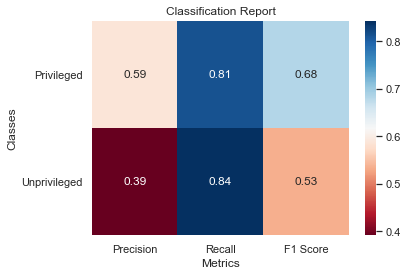

In [23]:
sampled_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    sampled_data, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


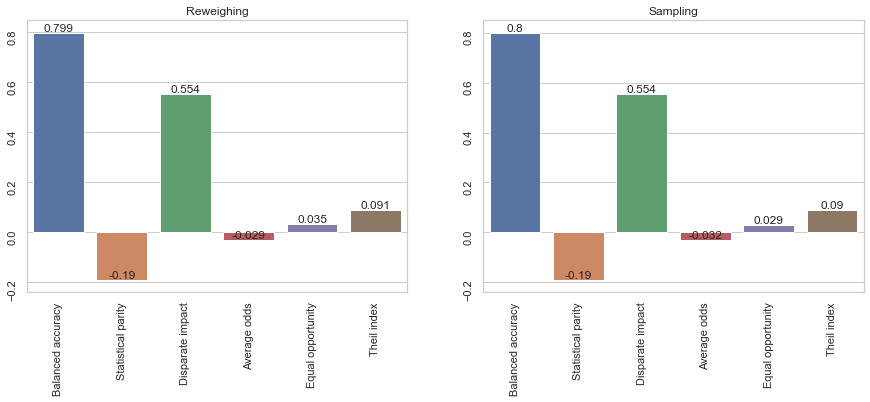

In [24]:
plot_metrics_comparison(rw_class, sampled_metrics, 'Reweighing', 'Sampling')
plt.show()

## Reweighing vs DIR vs Sampling

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Dataset,-0.2234,0.8121,0.2837,-0.1954,-0.3554,0.0823
DIR Dataset,-0.1679,0.8096,0.3477,-0.1193,-0.3156,0.0833
Reweighed Dataset,-0.0292,0.7990,0.5542,0.0348,-0.1896,0.0906
Sampled Dataset,-0.0320,0.8002,0.5539,0.0287,-0.1904,0.0899


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


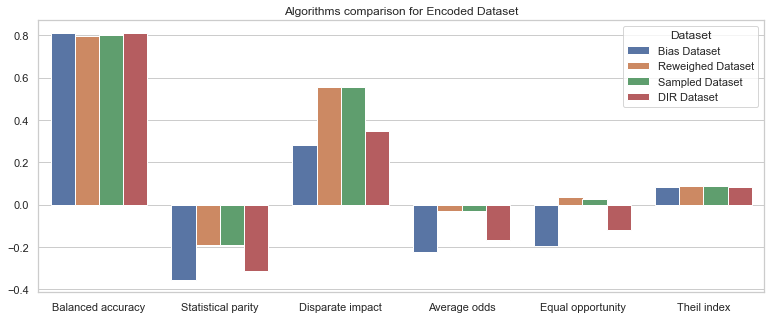

In [25]:
plot_syntesis(merge_datasets({
    'Bias Dataset': class_metrics,
    'Reweighed Dataset': rw_class,
    'Sampled Dataset': sampled_metrics,
    'DIR Dataset': dir_class,
}), "Algorithms comparison for Encoded Dataset")
plt.savefig(os.path.join(path, 'adult_synt.pdf'))
plt.show()

# Test with numerical data

In [26]:
df = load_dataset()
drop_cols = ['workclass', 'fnlwgt', 'education', 
             'marital-status', 'occupation', 'relationship', 'native-country','race']
df.drop(df[drop_cols], axis=1, inplace=True)
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['income'] = le.fit_transform(df['income'])
df

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income
0,39,13,1,2174,0,40,0
1,50,13,1,0,0,13,0
2,38,9,1,0,0,40,0
3,53,7,1,0,0,40,0
4,28,13,0,0,0,40,0
...,...,...,...,...,...,...,...
32556,27,12,0,0,0,38,0
32557,40,9,1,0,0,40,1
32558,58,9,0,0,0,40,0
32559,22,9,1,0,0,20,0


## Bias Dataset

In [27]:
df_bin = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=df, label_names=['income'], protected_attribute_names=['sex'])

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.7619
Statistical parity: -0.3605
Disparate impact: 0.2353
Average odds: -0.3089
Equal opportunity: -0.3652
Theil index: 0.1090


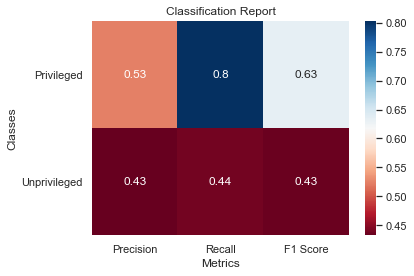

In [28]:
df_ord_class = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                        df_bin, privileged_group, unprivileged_group)

## Reweighing

In [29]:
rw = Reweighing(unprivileged_group, privileged_group)
df_bin_rw = df_bin.copy()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7364
Statistical parity: -0.0888
Disparate impact: 0.7659
Average odds: -0.0083
Equal opportunity: -0.0275
Theil index: 0.1210


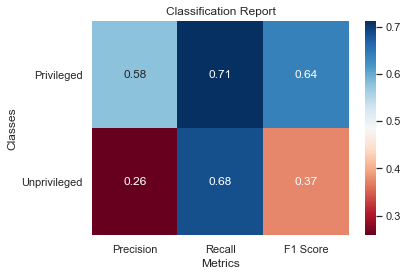

In [30]:
rw_ord_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    df_bin_rw, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


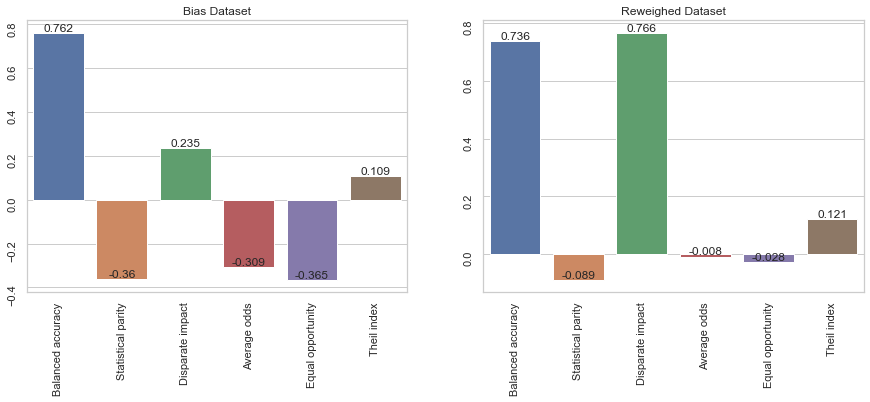

In [31]:
plot_metrics_comparison(df_ord_class, rw_ord_class, 'Bias Dataset', 'Reweighed Dataset')
plt.show()

## DIR

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


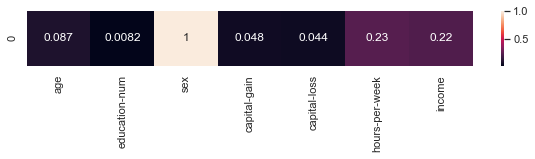

In [32]:
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr.T, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


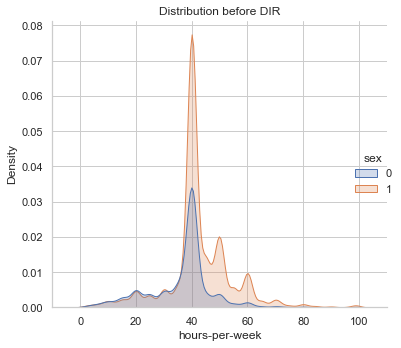

In [33]:
sns.displot(data=df, x='hours-per-week', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution before DIR')
plt.tight_layout()
plt.savefig('dir_num_bf.pdf')
plt.show()

In [34]:
df_dir = df_bin.copy()
scaler = MinMaxScaler(copy=False)
df_dir.features = scaler.fit_transform(df_bin.features)

In [35]:
di = DisparateImpactRemover(sensitive_attribute='sex')
df_dir = di.fit_transform(df_bin)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


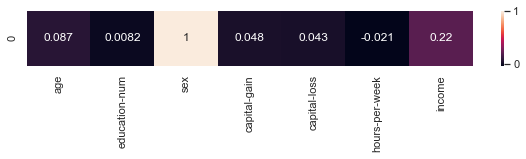

In [36]:
df = df_dir.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr.T, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


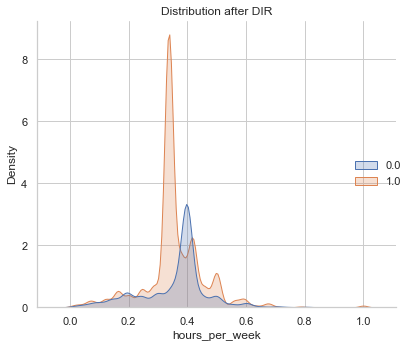

In [37]:
ax = sns.displot(x=df_dir.features[:,5], hue=df_dir.features[:,2], kind='kde', multiple='layer', fill=True)
plt.title('Distribution after DIR')
ax.set(xlabel='hours_per_week')
plt.tight_layout()
plt.savefig('dir_num_aft.pdf')
plt.show()

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.7322
Statistical parity: -0.0636
Disparate impact: 0.8300
Average odds: 0.0140
Equal opportunity: -0.0083
Theil index: 0.1225


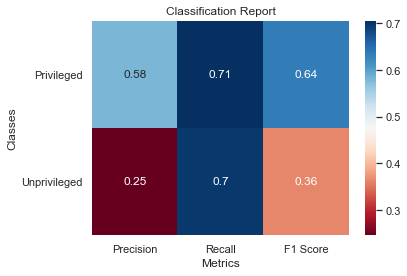

In [38]:
dir_ord_class = classify(make_pipeline(
    StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                         df_dir, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


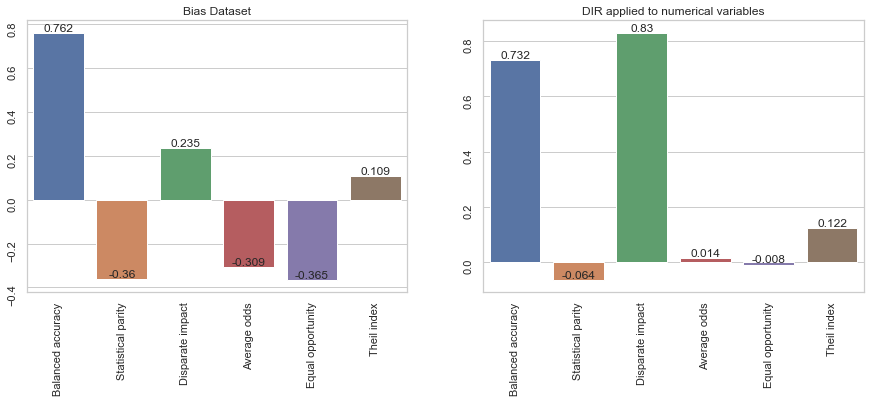

In [39]:
plot_metrics_comparison(df_ord_class, dir_ord_class, 'Bias Dataset', 'DIR applied to numerical variables')
plt.show()

## Modified Reweighing (Sampling)

In [40]:
sampler = Sampler(round_level=3)
sampled_num = df_bin.copy()

### Dataset Metrics:

Disparate Impact: 0.9990
Statistical Parity: -0.0003




### Classification Metrics:

Balanced accuracy: 0.7364
Statistical parity: -0.0860
Disparate impact: 0.7743
Average odds: -0.0052
Equal opportunity: -0.0239
Theil index: 0.1207


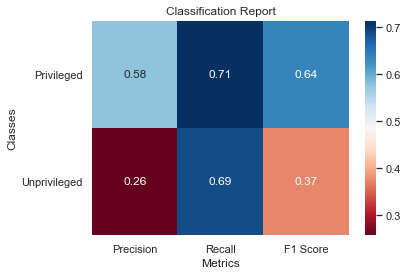

In [41]:
sampled_num_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_num, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


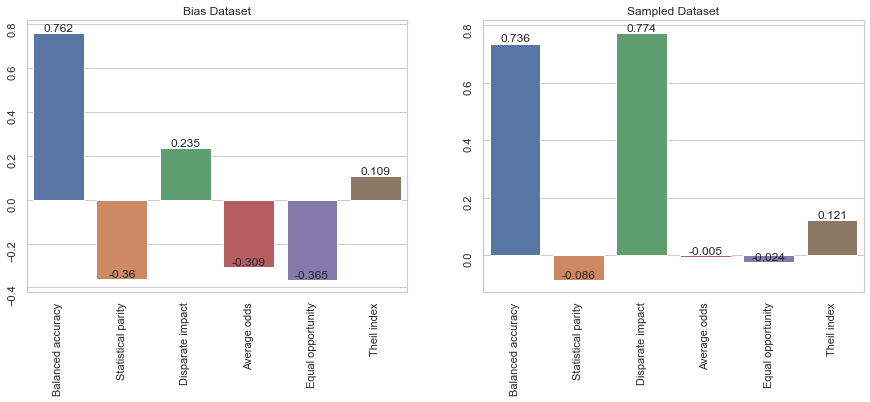

In [42]:
plot_metrics_comparison(df_ord_class, sampled_num_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs DIR vs Sampling

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Dataset,-0.3089,0.7619,0.2353,-0.3652,-0.3605,0.1090
DIR Dataset,0.0140,0.7322,0.8300,-0.0083,-0.0636,0.1225
Reweighed Dataset,-0.0083,0.7364,0.7659,-0.0275,-0.0888,0.1210
Sampled Dataset,-0.0052,0.7364,0.7743,-0.0239,-0.0860,0.1207


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


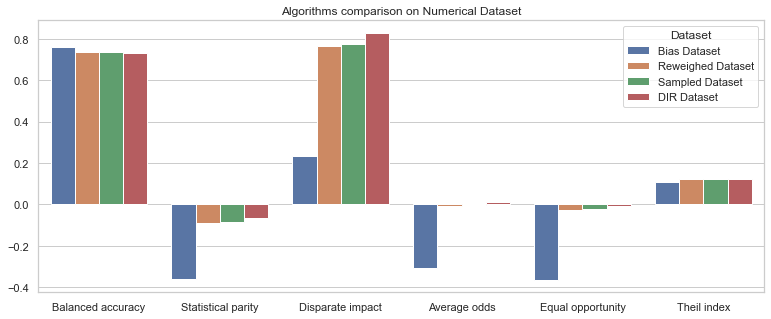

In [43]:
plot_syntesis(merge_datasets({
    'Bias Dataset': df_ord_class,
    'Reweighed Dataset': rw_ord_class,
    'Sampled Dataset': sampled_num_metrics,
    'DIR Dataset': dir_ord_class,
}), 'Algorithms comparison on Numerical Dataset')
plt.savefig(os.path.join(path, 'adult_num_syn.pdf'))
plt.show()

# Reweighing + DIR

## Dataset with One Hot Encoded attributes

In [44]:
rw_dir_enc = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.8033
Statistical parity: -0.2140
Disparate impact: 0.5072
Average odds: -0.0543
Equal opportunity: 0.0081
Theil index: 0.0885


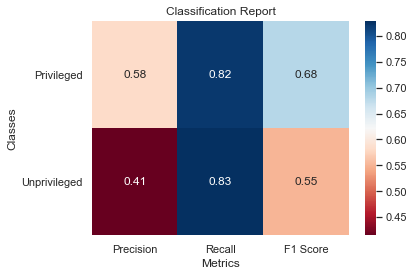

In [45]:
rw_dir_enc_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir_enc, privileged_group, unprivileged_group, sensitive_attributes=['sex'], debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


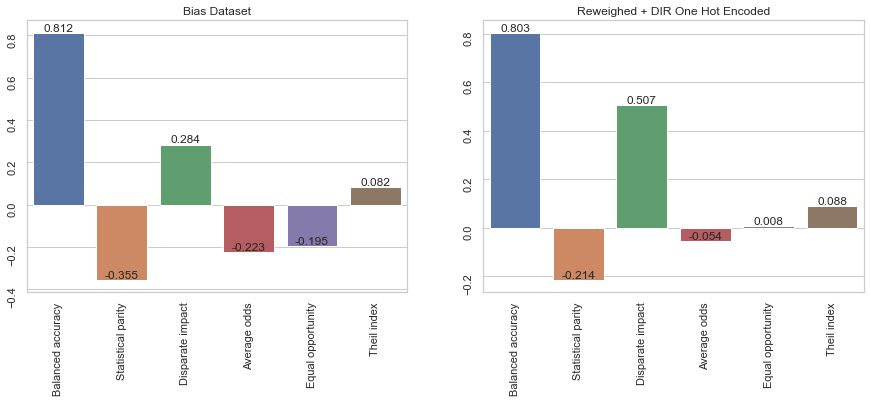

In [46]:
plot_metrics_comparison(class_metrics, rw_dir_enc_score, 'Bias Dataset', 'Reweighed + DIR One Hot Encoded')
plt.show()

## Dataset with numerical attributes

In [47]:
rw_dir_data = df_dir.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7319
Statistical parity: -0.0581
Disparate impact: 0.8442
Average odds: 0.0228
Equal opportunity: 0.0049
Theil index: 0.1229


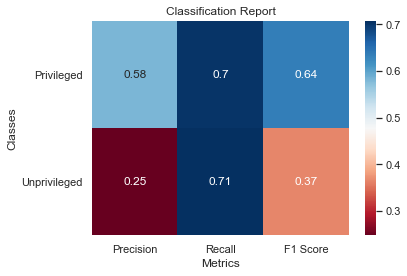

In [48]:
rw_dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_dir_data, privileged_group, unprivileged_group, sensitive_attributes=['sex'], debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


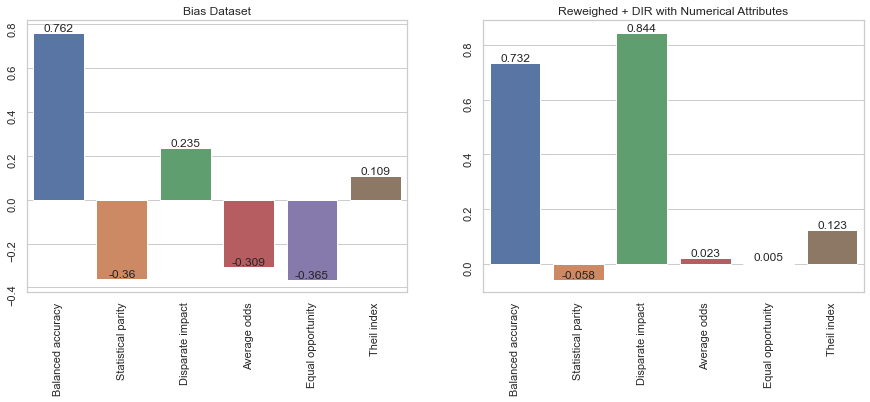

In [49]:
plot_metrics_comparison(df_ord_class, rw_dir_score, 'Bias Dataset', 'Reweighed + DIR with Numerical Attributes')
plt.show()

# Algorithms Comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Dataset One Hot,-0.2234,0.8121,0.2837,-0.1954,-0.3554,0.0823
Disparate Impact Remover One Hot,-0.1679,0.8096,0.3477,-0.1193,-0.3156,0.0833
Reweighing + DIR One Hot,-0.0543,0.8033,0.5072,0.0081,-0.2140,0.0885
Reweighing One Hot,-0.0292,0.7990,0.5542,0.0348,-0.1896,0.0906
Sampled One Hot,-0.0320,0.8002,0.5539,0.0287,-0.1904,0.0899


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


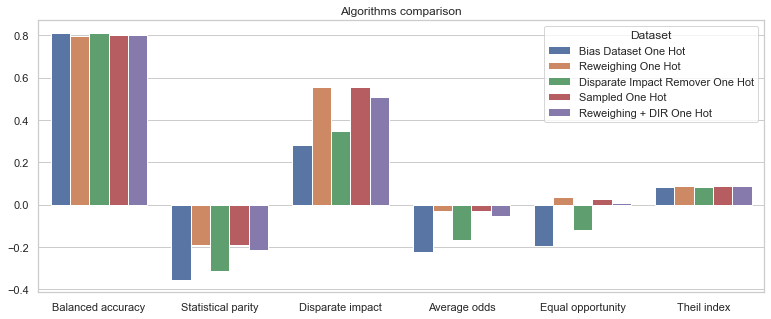

In [50]:
plot_syntesis(merge_datasets({
    'Bias Dataset One Hot': class_metrics,
    'Reweighing One Hot': rw_class,
    'Disparate Impact Remover One Hot': dir_class,
    'Sampled One Hot': sampled_metrics,
    'Reweighing + DIR One Hot': rw_dir_enc_score,
}), 'Algorithms comparison')
plt.savefig(os.path.join(path, 'adult_rw_dir_one_hot.pdf'))
plt.show()

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Dataset Num,-0.3089,0.7619,0.2353,-0.3652,-0.3605,0.1090
Disparate Impact Remover Num,0.0140,0.7322,0.8300,-0.0083,-0.0636,0.1225
Reweighing + DIR Num,0.0228,0.7319,0.8442,0.0049,-0.0581,0.1229
Reweighing Num,-0.0083,0.7364,0.7659,-0.0275,-0.0888,0.1210
Sampled Num,-0.0052,0.7364,0.7743,-0.0239,-0.0860,0.1207


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


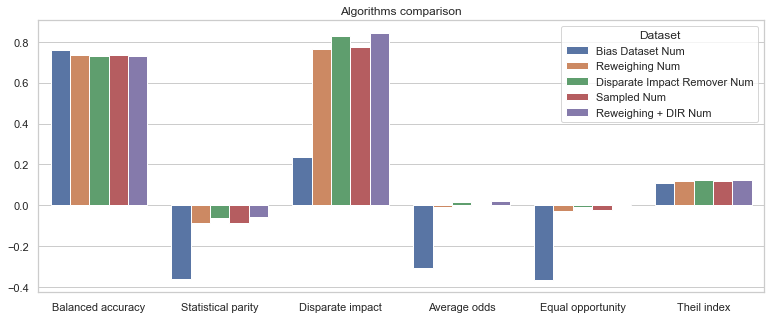

In [51]:
plot_syntesis(merge_datasets({
    'Bias Dataset Num': df_ord_class,
    'Reweighing Num': rw_ord_class,
    'Disparate Impact Remover Num': dir_ord_class,
    'Sampled Num': sampled_num_metrics,
    'Reweighing + DIR Num': rw_dir_score,
}), 'Algorithms comparison')
plt.savefig(os.path.join(path, 'adult_rw_dir_num.pdf'))
plt.show()

# Test Adult with multiple sensitive attributes

In [55]:
df_2 = load_dataset()
drop_cols = ['workclass', 'fnlwgt', 'education', 
             'marital-status', 'occupation', 'relationship', 'native-country']
df_2.drop(df_2[drop_cols], axis=1, inplace=True)

In [56]:
le = LabelEncoder()
df_2['sex'] = le.fit_transform(df_2['sex'])
df_2['race'] = le.fit_transform(df_2['race'])

In [57]:
perc = (df_2[['sex','race','income']]
            .groupby(['sex','race'])['income']
            .value_counts(normalize=True)
            .rename('Percentage')
            .reset_index())

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


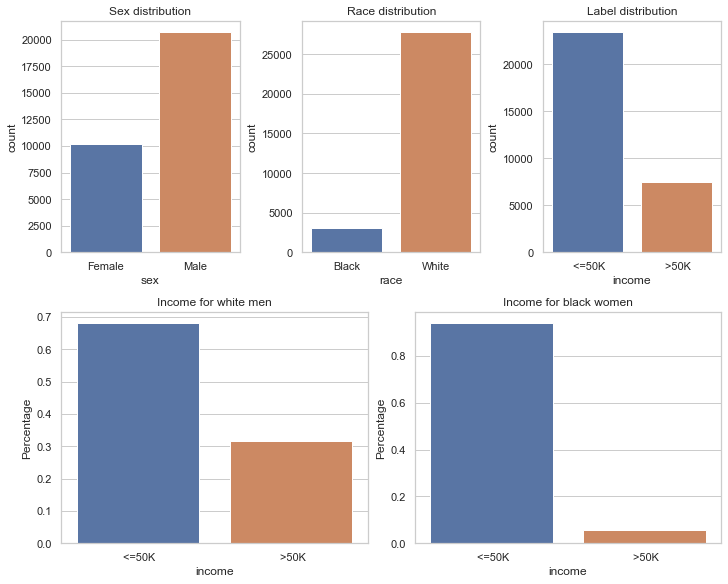

In [63]:
fig = plt.figure(figsize=(10,8), constrained_layout=True)
grid = GridSpec(2,6, figure=fig)
ax1 = fig.add_subplot(grid[0,0:2])
ax2 = fig.add_subplot(grid[0,2:4])
ax3 = fig.add_subplot(grid[0,4:])
ax4 = fig.add_subplot(grid[1,0:3])
ax5 = fig.add_subplot(grid[1,3:])
sns.countplot(data=df_2, x='sex', ax=ax1)
sns.countplot(data=df_2, x='race', ax=ax2)
sns.countplot(data=df_2, x='income', ax=ax3)
sns.barplot(data=perc[(perc['sex']==1)&(perc['race']==1)], x='income', y='Percentage', ax=ax4)
sns.barplot(data=perc[(perc['sex']==0)&(perc['race']==0)], x='income', y='Percentage', ax=ax5)
ax1.set_title('Sex distribution')
ax1.set_xticklabels(['Female', 'Male'])
ax2.set_title('Race distribution')
ax2.set_xticklabels(['Black', 'White'])
ax3.set_title('Label distribution')
ax4.set_title('Income for white men')
ax5.set_title('Income for black women')
plt.savefig(os.path.join(path, 'adult_multi_distr.pdf'))
plt.show()

In [15]:
df_2[(df_2['sex']==0)&(df_2['race']==0)].shape

(1555, 8)

In [16]:
df_2[(df_2['sex']==1)&(df_2['race']==1)].shape

(19174, 8)

In [17]:
df_2['income'] = le.fit_transform(df_2['income'])

In [18]:
privileged_group = [{'sex': 1, 'race': 1}]
unprivileged_group = [{'sex': 0, 'race': 0}]

## Test on bias dataset

In [19]:
df_2bin = BinaryLabelDataset(df=df_2, protected_attribute_names = ['sex', 'race'], label_names=['income'])

invalid value encountered in double_scalars


### Dataset Metrics:

Disparate Impact: 0.1823
Statistical Parity: -0.2597




### Classification Metrics:

Balanced accuracy: 0.7621
Statistical parity: -0.4529
Disparate impact: 0.0864
Average odds: -0.3972
Equal opportunity: -0.4707
Theil index: 0.1084


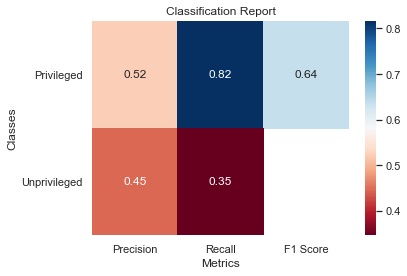

In [20]:
df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    df_2bin, privileged_group, unprivileged_group)

## Reweighing

In [21]:
rw = Reweighing(unprivileged_group, privileged_group)
df2_rw = df_2bin.copy()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7488
Statistical parity: -0.2488
Disparate impact: 0.3405
Average odds: -0.1355
Equal opportunity: -0.1464
Theil index: 0.1226


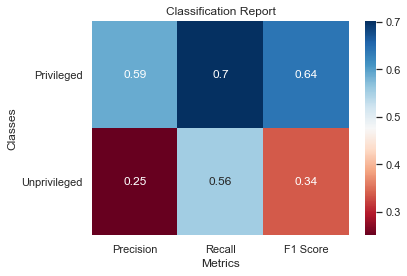

In [22]:
rw_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    df2_rw, privileged_group, unprivileged_group, debiaser=rw)

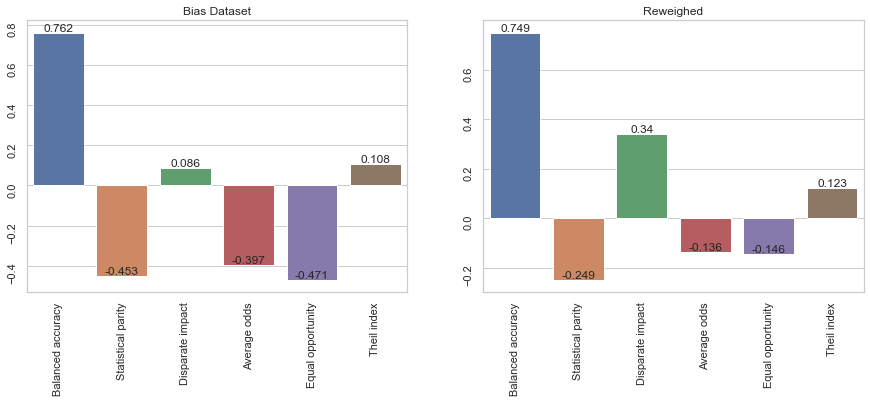

In [23]:
plot_metrics_comparison(df2_class, rw_df2_class, 'Bias Dataset', 'Reweighed')
plt.show()

## Modified Reweighing (Sampling)

In [24]:
sampled2 = df_2bin.copy()
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 0.9866
Statistical Parity: -0.0033




### Classification Metrics:

Balanced accuracy: 0.7371
Statistical parity: -0.1637
Disparate impact: 0.5818
Average odds: -0.0368
Equal opportunity: -0.0328
Theil index: 0.1209


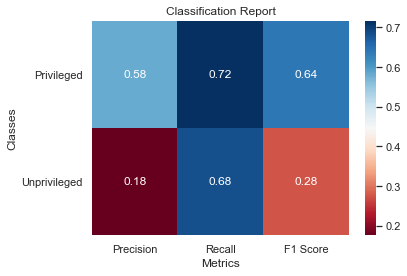

In [25]:
sampled_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled2, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

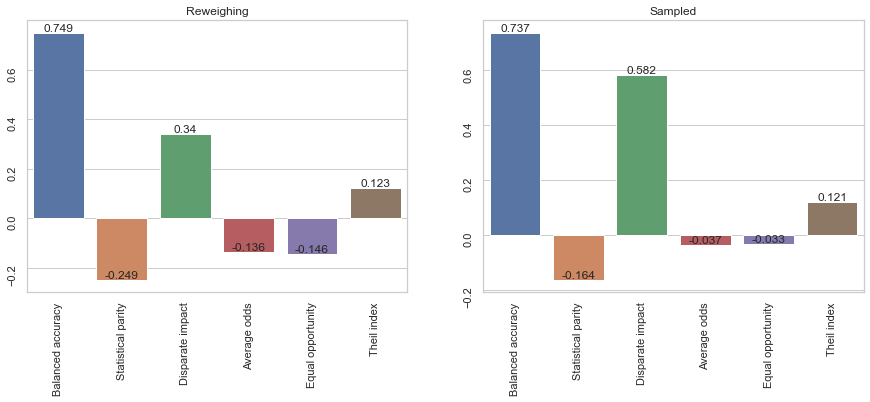

In [26]:
plot_metrics_comparison(rw_df2_class, sampled_df2_class, 'Reweighing', 'Sampled')
plt.show()

## Disparate Impact Remover

In [27]:
dir2 = df_2bin.copy()
scaler = MinMaxScaler(copy=False)
dir2.features = scaler.fit_transform(dir2.features)
df = dir2.convert_to_dataframe()[0]

In [28]:
probs = (
    df.value_counts(["sex", "race"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='race', value_name='probs'))

for sex,race,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['race'] == race), 'prob'] = prob

df.drop(df[['sex','race']], axis=1, inplace=True)

In [29]:
di = DisparateImpactRemover(sensitive_attribute='prob')
dir2 = BinaryLabelDataset(df = df, label_names=['income'], protected_attribute_names=['prob'])
dir2 = di.fit_transform(dir2)

In [30]:
df = dir2.convert_to_dataframe()[0]
df.loc[df['prob'].round(6) == 0.050259, 'prob'] = 0
df.loc[df['prob'].round(6) != 0, 'prob'] = 1

prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]
dir2 = BinaryLabelDataset(df = df, label_names=['income'], protected_attribute_names=['prob'])

### Dataset Metrics:

Disparate Impact: 0.2294
Statistical Parity: -0.1944




### Classification Metrics:

Balanced accuracy: 0.7290
Statistical parity: -0.0519
Disparate impact: 0.8547
Average odds: 0.0348
Equal opportunity: 0.0334
Theil index: 0.1239


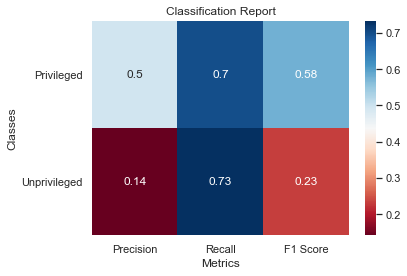

In [31]:
dir_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir2, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'])

## Reweighing + DIR

In [32]:
dir_rw_2 = dir2.copy()
rw = Reweighing(prob_unpriv_group, prob_priv_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7281
Statistical parity: -0.0455
Disparate impact: 0.8711
Average odds: 0.0602
Equal opportunity: 0.0782
Theil index: 0.1245


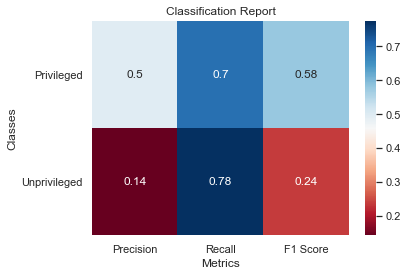

In [33]:
dir_rw_2_class = classify( 
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_rw_2, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'], debiaser=rw)

## Algorithms comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Dataset,-0.3972,0.7621,0.0864,-0.4707,-0.4529,0.1084
DIR,0.0348,0.7290,0.8547,0.0334,-0.0519,0.1239
Reweighed,-0.1355,0.7488,0.3405,-0.1464,-0.2488,0.1226
Reweighing + DIR,0.0602,0.7281,0.8711,0.0782,-0.0455,0.1245
Sampled,-0.0368,0.7371,0.5818,-0.0328,-0.1637,0.1209


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


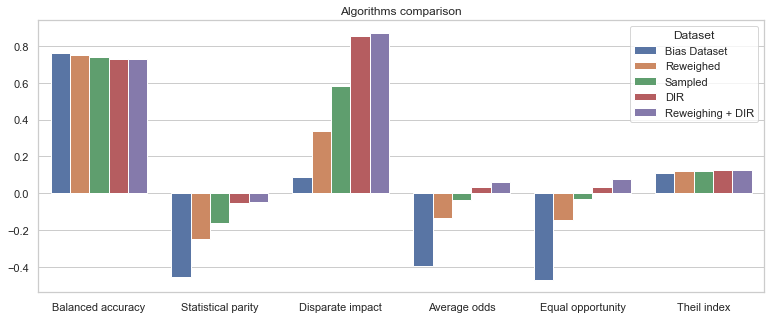

In [64]:
plot_syntesis(merge_datasets({
    'Bias Dataset': df2_class,
    'Reweighed': rw_df2_class,
    'Sampled': sampled_df2_class,
    'DIR': dir_df2_class,
    'Reweighing + DIR': dir_rw_2_class,
}), 'Algorithms comparison')
plt.savefig(os.path.join(path, 'adult_multi_metrics.pdf'))
plt.show()